In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import astropy.units as u
import astropy.io.fits as fits

import glob

# Holy shit it worked.

from lsst.sims.photUtils.Sed import Sed
from lsst.sims.photUtils.Bandpass import Bandpass 
# Well, it kind of worked. For some reason have to do it this way, with two lines instead of one, or it returns
# a "ModuleNotFoundError - No module named lsst.utils", or something to that effect.

import os

In [5]:
# Grab the current directory
cwd = os.getcwd()
# just one dir to start
directory = os.path.join(cwd, 'ckm05')
filepath = glob.glob(os.path.join(directory,'*.fits'))

In [6]:
# 
hdul = fits.open(filepath[-11])
# The header says what the 
header = hdul[0].header.copy()
spec_table = hdul[1].data.copy()
hdul.close()

In [7]:
header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    0 / Number of axes                                 
EXTEND  =                    T / File may contain extensions                    
DATE    = '2007-01-09T16:25:07' / Date FITS file was generated                  
IRAF-TLM= '11:25:19 (09/01/2007)' / Time of last modification                   
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'STScI-STSDAS/TABLES' / Tables version 2002-02-22                     
FILENAME= 'ckm05_7250.fits'    / name of file                                   
NEXTEND =                    1 / number of extensions in file                   
TEFF    =                 7250                                                  
LOG_Z   =                 -0

(1000, 10000)

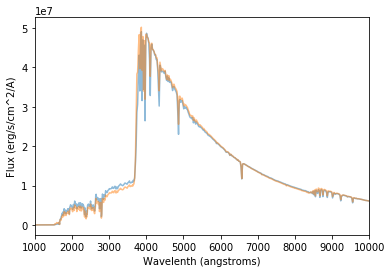

In [8]:
# Let's see what a few of them look like
plt.plot(spec_table['WAVELENGTH'], spec_table['g15'], alpha=0.5)
plt.plot(spec_table['WAVELENGTH'], spec_table['g05'], alpha=.5)
# Always always keep track of units!
plt.xlabel('Wavelenth (angstroms)')
plt.ylabel('Flux (erg/s/cm^2/A)')
plt.xlim([1000,10000])

In [9]:
# OK, those look like stellar spectra I can believe in.

In [10]:
# Had to comment out the os functions and import the filters using my specific directory stuff.
# Python couldn't find LSST_THROUGHPUTS_BASELINE and this was just the quickest way to troubleshoot.

band_dir = '/Users/ichorgodbel-shamroth/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/throughputs/2017.01.31-6-g29ce4f5/baseline/'

In [11]:
# LSST standard is nm rather than Ang. I think I did this right.
my_sed = Sed(wavelen=spec_table['WAVELENGTH']/10., flambda=spec_table['g15']*10)

In [12]:
# now to read in an LSST bandpass

#band_dir = os.getenv("LSST_THROUGHPUTS_BASELINE")

filterlist =['u', 'g', 'r', 'i', 'z', 'y']
bps = []
for filtername in filterlist:
    tempB = Bandpass()
    #tempB.readThroughput(os.path.join(band_dir, 'filter_'+filtername+'.dat'))
    tempB.readThroughput(band_dir+'filter_'+filtername+'.dat')
    bps.append(tempB)

In [13]:
bps

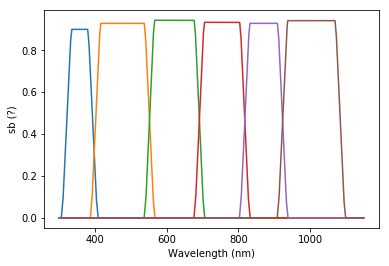

In [14]:
# Let's plot a few bandpass objects to make sure they look right
for bp in bps:
    plt.plot(bp.wavelen, bp.sb)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('sb (?)');

In [15]:
for filtername, bp in zip(filterlist, bps):
    print(filtername, my_sed.calcMag(bp))

u -38.363286413963436
g -39.59327802655636
r -39.52419558206158
i -39.41067490412371
z -39.38876055845057
y -39.351077441196864


In [16]:
# OK, that looks scary (because the sun only has an apparent mag of -27), but we never said 
#what distance the stars are at. So we can just add a constant to all the mags and it's fine.


Some good next steps:
* grab the narrow band filter throughputs from that survey, and figure out how to read them into bandpass objects - check
* Once we have all the filters and the stellar spectra, time to build a giant array! Each row would have star Teff, logg, metallicity, and then magnitudes in each LSST filter and narrowband filter. Can save the whole thing as a numpy zip file for easy reloading

# SPLUS Survey Narrowband Filters:

In [17]:
splus_filt_dir = os.path.join(cwd, 'splus_filter_curves/')

In [18]:
narrowbandfiltlist = ['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861']

splus_narrowbands = []

# Only problem with getting the splus survey narrowbands to fit into the Bandpass object was
# that I needed to specify a max and min wavelength for some reason. Once they were explicitly
# defined, however, it went pretty smoothly.

for filtername in narrowbandfiltlist:
    tempB2 = Bandpass(wavelen_min=3000, wavelen_max=9000)
    tempB2.readThroughput(splus_filt_dir+filtername+'.dat')
    splus_narrowbands.append(tempB2)

In [19]:
splus_narrowbands

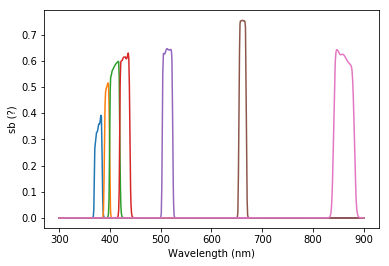

In [20]:
# plotting again to make sure they've come out right

for bp in splus_narrowbands:
    plt.plot(bp.wavelen/10, bp.sb)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('sb (?)');

In [21]:
# judging by the plot, the magnitudes, and the magitudes from your example, it looks right\

for filtername, bp in zip(narrowbandfiltlist, splus_narrowbands):
    print(filtername, my_sed.calcMag(bp))

F378 -37.24489716943626
F395 -37.165925637468774
F410 -37.08693588648791
F430 -36.99837481416216
F515 -36.63665694365109
F660 -36.12280452787408
F861 -35.573271981260476


# Experimentation:

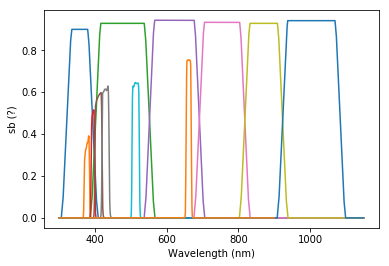

In [22]:
# Plotting it this way cuts off the last (~8500-9000 angstrom) filter. No idea why.

for bp, nbp in zip(bps, splus_narrowbands):
    plt.plot(bp.wavelen, bp.sb, nbp.wavelen/10, nbp.sb)
    
plt.xlabel('Wavelength (nm)')
plt.ylabel('sb (?)');

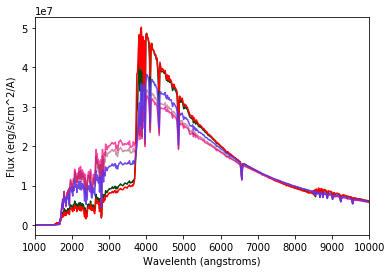

In [23]:
# messing around with the fits files and the spectra contained within.
# Not sure I get what the different log(g) values entail, exactly

plt.plot(spec_table['WAVELENGTH'], spec_table['g15'], alpha=1.0, color='xkcd:british racing green')
plt.plot(spec_table['WAVELENGTH'], spec_table['g05'], alpha=1.0, color='r')
plt.plot(spec_table['WAVELENGTH'], spec_table['g50'], alpha=1.0, color='xkcd:barbie pink')
plt.plot(spec_table['WAVELENGTH'], spec_table['g45'], alpha=0.4, color='xkcd:bordeaux')
plt.plot(spec_table['WAVELENGTH'], spec_table['g35'], alpha=0.9, color='xkcd:purpley blue')

plt.xlabel('Wavelenth (angstroms)')
plt.ylabel('Flux (erg/s/cm^2/A)')
plt.xlim([1000,10000]);

In [24]:
plt.style.use('ggplot')

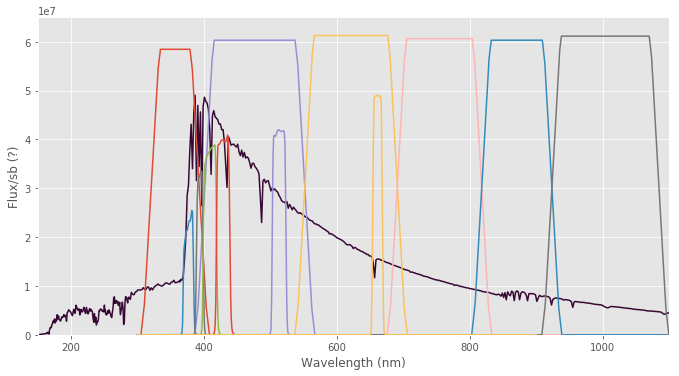

In [25]:
# y-axis is a mess here, but wanted one of the spectra and the filter bands overlaid

fig,ax = plt.subplots(1,1)                 
fig.set_size_inches(9.5,5)                  

fig.tight_layout()                          

ax.set_xlim(150,1100)
ax.set_ylim(0,6.5*10**7)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Flux/sb (?)")

ax.plot(spec_table['WAVELENGTH']/10, spec_table['g15'], alpha=1.0, color='xkcd:eggplant')
for bp, nbp in zip(bps, splus_narrowbands):
    ax.plot(bp.wavelen, bp.sb*6.5*10**7, nbp.wavelen/10, nbp.sb*6.5*10**7);

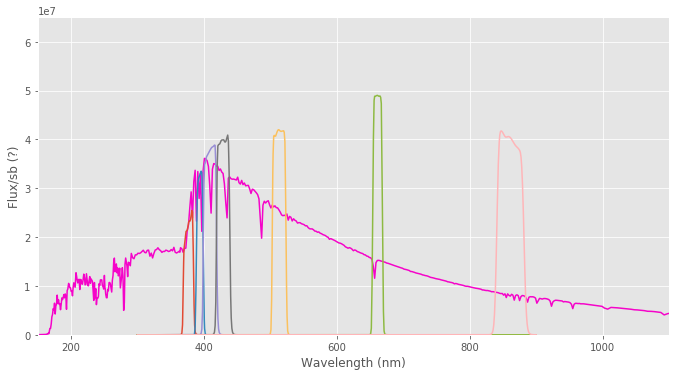

In [26]:
# now just for the narrowbands

fig,ax = plt.subplots(1,1)                 
fig.set_size_inches(9.5,5)                  

fig.tight_layout()                          


ax.set_xlim(150,1100)
ax.set_ylim(0,6.5*10**7)

ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Flux/sb (?)")

# just pretend that in the case of the filter bands, 6.5*10^7 is the same thing as 1

ax.plot(spec_table['WAVELENGTH']/10, spec_table['g40'], alpha=1.0, color='xkcd:hot magenta')
for bp in splus_narrowbands:
    ax.plot(bp.wavelen/10, bp.sb*6.5*10**7);

# Putting the Bits Together:

In [27]:
# mainly to remind myself what goes in the array

giant_array_cols = ['Teff', 'log(g)', 'Metallicity', 'u', 'g', 'r', 'i', 'z', 'y', 
               'F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861']

In [28]:
# T_eff/metallicity for each star in the ckm05 directory. Of course as every log_Z is -1/2, that
# one is not particularly exciting in this case:

for filename in filepath:
    
    hdul2 = fits.open(filename)
    header1 = hdul2[0].header.copy()
    spec_table1 = hdul2[1].data.copy()
    hdul2.close()
    teff = header1['TEFF']
    hella_metal = header1['LOG_Z']
    
    for filtername, bp in zip(narrowbandfiltlist, splus_narrowbands):
        
        modest_array = [teff, hella_metal]
        
    print(modest_array)

[10000, -0.5]
[10250, -0.5]
[10500, -0.5]
[10750, -0.5]
[11000, -0.5]
[11250, -0.5]
[11500, -0.5]
[11750, -0.5]
[12000, -0.5]
[12250, -0.5]
[12500, -0.5]
[12750, -0.5]
[13000, -0.5]
[14000, -0.5]
[15000, -0.5]
[16000, -0.5]
[17000, -0.5]
[18000, -0.5]
[19000, -0.5]
[20000, -0.5]
[21000, -0.5]
[22000, -0.5]
[23000, -0.5]
[24000, -0.5]
[25000, -0.5]
[26000, -0.5]
[27000, -0.5]
[28000, -0.5]
[29000, -0.5]
[30000, -0.5]
[31000, -0.5]
[32000, -0.5]
[33000, -0.5]
[34000, -0.5]
[3500, -0.5]
[35000, -0.5]
[36000, -0.5]
[37000, -0.5]
[3750, -0.5]
[38000, -0.5]
[39000, -0.5]
[4000, -0.5]
[40000, -0.5]
[41000, -0.5]
[42000, -0.5]
[4250, -0.5]
[43000, -0.5]
[44000, -0.5]
[4500, -0.5]
[45000, -0.5]
[46000, -0.5]
[47000, -0.5]
[4750, -0.5]
[48000, -0.5]
[49000, -0.5]
[5000, -0.5]
[50000, -0.5]
[5250, -0.5]
[5500, -0.5]
[5750, -0.5]
[6000, -0.5]
[6250, -0.5]
[6500, -0.5]
[6750, -0.5]
[7000, -0.5]
[7250, -0.5]
[7500, -0.5]
[7750, -0.5]
[8000, -0.5]
[8250, -0.5]
[8500, -0.5]
[8750, -0.5]
[9000, -0.5]
[

### General reminder to myself re: procedure: for each spectrum in each of the directories, need T_eff, metallicity, & magnitudes in each narrowband & lsst filter at each value of log(g).

In [29]:
# uncomment if you for whatever reason want to look at the second header:

hdul = fits.open(filepath[-11])
header3 = hdul[1].header.copy()
hdul.close()

#header3

In [62]:
metallicity_keys = ['g00', 'g05', 'g10', 'g15', 'g20', 'g25', 'g30', 'g35', 'g40', 'g45', 'g50']
# uh I thought log(Z) was metallicity; isn't the gXX stuff gravity?
list_list =[]

for filename in filepath:
    
    hdul2 = fits.open(filename)
    header1 = hdul2[0].header.copy()
    spec_table1 = hdul2[1].data.copy()
    
    for metallicity in metallicity_keys:
        # order will be filename, Teff, Fe/H, logg, ...
        star_properties = []
        #star_properties.append(filename)
        teff = header1['TEFF']
        hella_metal = header1['LOG_Z']
        star_properties.append(teff)
        star_properties.append(hella_metal)
        my_seds = Sed(wavelen=spec_table1['WAVELENGTH']/10, flambda=spec_table1[metallicity]*10)
        
        # okay, so the exact nested loop syntax is getting better but still needs some work
        
        for filtername, bp in zip(narrowbandfiltlist, splus_narrowbands):
            
            for filtername1, bbp in zip(filterlist, bps):
                
                flux = my_seds.calcFlux(bp)
                flux1 = my_seds.calcFlux(bbp)
                
                if flux > 0:
                    
                    nb_mag = my_seds.calcMag(bp)
                    star_properties.append(nb_mag)
                    
                    if flux1 > 0:
                        
                        bb_mag = my_seds.calcMag(bbp)
                        star_properties.append(bb_mag)
                        
                        list_list.append(star_properties)
print(list_list[0])
hdul2.close()

[10000, -0.5, -37.60078122573802, -40.05998944177267, -37.60078122573802, -40.703819314921134, -37.60078122573802, -40.45109888362424, -37.60078122573802, -40.21942467745585, -37.60078122573802, -40.1112659190769, -37.60078122573802, -39.98030253521431, -37.518682012761786, -40.05998944177267, -37.518682012761786, -40.703819314921134, -37.518682012761786, -40.45109888362424, -37.518682012761786, -40.21942467745585, -37.518682012761786, -40.1112659190769, -37.518682012761786, -39.98030253521431, -37.438457204041626, -40.05998944177267, -37.438457204041626, -40.703819314921134, -37.438457204041626, -40.45109888362424, -37.438457204041626, -40.21942467745585, -37.438457204041626, -40.1112659190769, -37.438457204041626, -39.98030253521431, -37.34700909532317, -40.05998944177267, -37.34700909532317, -40.703819314921134, -37.34700909532317, -40.45109888362424, -37.34700909532317, -40.21942467745585, -37.34700909532317, -40.1112659190769, -37.34700909532317, -39.98030253521431, -36.9792270512

In [63]:
# well, it's a start...

### Experimentation on importing all the other directories:

In [64]:
spectra_directory_keys = ['ckm05', 'ckm10', 'ckm15', 'ckm20', 'ckm25', 'ckp00', 'ckp02', 'ckp05']

for spectra_directory in spectra_directory_keys:
    directory = os.path.join(cwd, spectra_directory)
    filepath = glob.glob(os.path.join(directory,'*.fits'))
    print(filepath)

['/Users/ichorgodbel-shamroth/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_photUtils/2.5.0.sims/python/ckm05/ckm05_10000.fits', '/Users/ichorgodbel-shamroth/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_photUtils/2.5.0.sims/python/ckm05/ckm05_10250.fits', '/Users/ichorgodbel-shamroth/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_photUtils/2.5.0.sims/python/ckm05/ckm05_10500.fits', '/Users/ichorgodbel-shamroth/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_photUtils/2.5.0.sims/python/ckm05/ckm05_10750.fits', '/Users/ichorgodbel-shamroth/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_photUtils/2.5.0.sims/python/ckm05/ckm05_11000.fits', '/Users/ichorgodbel-shamroth/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_photUtils/2.5.0.sims/python/ckm05/ckm05_11250.fits', '/Users/ichorgodbel-shamroth/lsst_stack/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/sims_photUtils/2.5.0.sims/python/ckm05/ckm05_11500.fits', '/Users/ichorgodbel

In [65]:
# looks like that got all of them, now to build that gigantic array

In [42]:
spectra_directory_keys = ['ckm05', 'ckm10', 'ckm15', 'ckm20', 'ckm25', 'ckp00', 'ckp02', 'ckp05']
metallicity_keys = ['g00', 'g05', 'g10', 'g15', 'g20', 'g25', 'g30', 'g35', 'g40', 'g45', 'g50']
list_list =[]

for spectra_directory in spectra_directory_keys:
    directory = os.path.join(cwd, spectra_directory)
    filepath = glob.glob(os.path.join(directory,'*.fits'))
    
    for filename in filepath:
    
        hdul2 = fits.open(filename)
        header1 = hdul2[0].header.copy()
        spec_table1 = hdul2[1].data.copy()

        for metallicity in metallicity_keys:
            # order will be filename, Teff, Fe/H, logg, ...
            star_properties = []
            star_properties.append(os.path.basename(filename))
            teff = header1['TEFF']
            hella_metal = header1['LOG_Z']
            star_properties.append(teff)
            star_properties.append(hella_metal)
            my_seds = Sed(wavelen=spec_table1['WAVELENGTH']/10, flambda=spec_table1[metallicity]*10)

            # okay, so the exact nested loop syntax is getting better but still needs some work

            for filtername, bp in zip(narrowbandfiltlist, splus_narrowbands):

                for filtername1, bbp in zip(filterlist, bps):

                    flux = my_seds.calcFlux(bp)
                    flux1 = my_seds.calcFlux(bbp)

                    if flux > 0:

                        nb_mag = my_seds.calcMag(bp)
                        star_properties.append(nb_mag)

                        if flux1 > 0:

                            bb_mag = my_seds.calcMag(bbp)
                            star_properties.append(bb_mag)

                            list_list.append(star_properties)
print(list_list[0])
hdul2.close()
    

['ckm05_10000.fits', 10000, -0.5, -37.60078122573802, -40.05998944177267, -37.60078122573802, -40.703819314921134, -37.60078122573802, -40.45109888362424, -37.60078122573802, -40.21942467745585, -37.60078122573802, -40.1112659190769, -37.60078122573802, -39.98030253521431, -37.518682012761786, -40.05998944177267, -37.518682012761786, -40.703819314921134, -37.518682012761786, -40.45109888362424, -37.518682012761786, -40.21942467745585, -37.518682012761786, -40.1112659190769, -37.518682012761786, -39.98030253521431, -37.438457204041626, -40.05998944177267, -37.438457204041626, -40.703819314921134, -37.438457204041626, -40.45109888362424, -37.438457204041626, -40.21942467745585, -37.438457204041626, -40.1112659190769, -37.438457204041626, -39.98030253521431, -37.34700909532317, -40.05998944177267, -37.34700909532317, -40.703819314921134, -37.34700909532317, -40.45109888362424, -37.34700909532317, -40.21942467745585, -37.34700909532317, -40.1112659190769, -37.34700909532317, -39.9803025352

In [ ]:
# so clearly the when to loop what syntax still needs work, as it's right now you
# can't tell between the different metallicities/gravity/whatever it is

### Super-professional non-profanity-laced experimentation into trying to get not the whole filepath:

In [39]:
spectra_directory_keys = ['ckm05', 'ckm10', 'ckm15', 'ckm20', 'ckm25', 'ckp00', 'ckp02', 'ckp05']
file_names = []

for spectra_directory in spectra_directory_keys:
    
    directory = os.path.join(cwd, spectra_directory)
    filepath = glob.glob(os.path.join(directory, '*.fits'))
    
    for filename in filepath:
        
        file_names.append(os.path.basename(filename))
        
print(file_names)

['ckm05_10000.fits', 'ckm05_10250.fits', 'ckm05_10500.fits', 'ckm05_10750.fits', 'ckm05_11000.fits', 'ckm05_11250.fits', 'ckm05_11500.fits', 'ckm05_11750.fits', 'ckm05_12000.fits', 'ckm05_12250.fits', 'ckm05_12500.fits', 'ckm05_12750.fits', 'ckm05_13000.fits', 'ckm05_14000.fits', 'ckm05_15000.fits', 'ckm05_16000.fits', 'ckm05_17000.fits', 'ckm05_18000.fits', 'ckm05_19000.fits', 'ckm05_20000.fits', 'ckm05_21000.fits', 'ckm05_22000.fits', 'ckm05_23000.fits', 'ckm05_24000.fits', 'ckm05_25000.fits', 'ckm05_26000.fits', 'ckm05_27000.fits', 'ckm05_28000.fits', 'ckm05_29000.fits', 'ckm05_30000.fits', 'ckm05_31000.fits', 'ckm05_32000.fits', 'ckm05_33000.fits', 'ckm05_34000.fits', 'ckm05_3500.fits', 'ckm05_35000.fits', 'ckm05_36000.fits', 'ckm05_37000.fits', 'ckm05_3750.fits', 'ckm05_38000.fits', 'ckm05_39000.fits', 'ckm05_4000.fits', 'ckm05_40000.fits', 'ckm05_41000.fits', 'ckm05_42000.fits', 'ckm05_4250.fits', 'ckm05_43000.fits', 'ckm05_44000.fits', 'ckm05_4500.fits', 'ckm05_45000.fits', 'ckm

### Success!